In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

#from table_maker import *

import pickle

from functools import partial

from itertools import product

from math import ceil

import warnings

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

In [3]:
def Unum(ξ, μ, α, γ, θ, Δ, c):
    return (1.0/2.0)*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((1.0/2.0)*(-np.exp(Δ)/(μ*c - 1) + 1.0/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((θ + (-( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + ((1.0/2.0)*μ*c - 1.0/2.0)*np.exp(-Δ) + 1.0/2.0)/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*np.exp(ξ/(μ*c)) + 1 - 1.0/2.0*np.exp(-Δ)*np.exp(-ξ)/(μ*c + 1) + (1.0/2.0)*np.exp(ξ)/(μ*c - 1))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)

def Anum(ξ, μ, α, γ, θ, Δ, c):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)

def find_root_indices(ys):
    # roots can be identified as a sign change from one point to the next.
    # if the product of two consective points is negative, then the sign changed.
    # if the product is zero, then one of the two points is the root
    root_mask = (ys[:-1]*ys[1:] <= 0) & (ys[1:]!=0) # locate roots
    root_indices = np.arange(len(ys)-1)[root_mask] # extract indices
    
    assert len(root_indices)%2 == 0 # ensure that there are an even number of roots
    left_roots = [root for root in root_indices[::2]]
    right_roots = [root for root in root_indices[1::2]]      
    for left_root, right_root in zip(left_roots, right_roots):
        assert ys[left_root]<0  and 0<ys[left_root+1]
        assert 0<ys[right_root] and ys[right_root+1]<0
    return root_indices

def refine_root(root_index, xs, ys, h, spatial_order):
    assert spatial_order >= 1
    if spatial_order == 1:
        return xs[root_index]
    # otherwise, interpolate and root-find
    stencil_size = spatial_order + 1
    half_stencil_size = stencil_size//2
    stencil = np.arange(  -half_stencil_size , -half_stencil_size + stencil_size)
    y_local = ys[root_index + stencil]
    coeffs = la.solve( np.array( [stencil**i for i in range(len(stencil))] ).T, y_local)

    my_f = lambda x: sum(c*x**i for (i,c) in enumerate(coeffs))
    d_coeffs = [i*c for (i,c) in enumerate(coeffs)][1:]
    my_df = lambda x: sum(c*x**i for (i,c) in enumerate(d_coeffs))

    my_root = 0
    for i in range(10):
        my_root -= my_f(my_root)/my_df(my_root)
    assert 0<= my_root and my_root <= 1 # interpolation failed
    return my_root*h + xs[root_index]

def refine_root_safe(root_index, xs, ys, h, spatial_order):
    try:
        root = refine_root(root_index, xs, ys, h, spatial_order)
    except:
        warnings.warn("Order %d interpolation failed. Reverting to Order 1 interpolation." % spatial_order)
        # linear interpolation will be safer
        root = refine_root(root_index, xs, ys, h, spatial_order=1)
    return root

def find_roots(xs, ys, h, spatial_order=4):
    return [ refine_root_safe(root_index, xs, ys, h, spatial_order=spatial_order) for root_index in  find_root_indices(ys) ]

def convolution(xs, ys, h, spatial_order):
    roots = find_roots(xs, ys, h, spatial_order)
    assert len(roots)%2 == 0 # ensure that there are an even number of roots
    left_roots = [root for root in roots[::2]]
    right_roots = [root for root in roots[1::2]]
    
    ret = xs*0
                   
    for root_left, root_right in zip(left_roots, right_roots):
        
        left_mask = xs <= root_left
        ret[left_mask] += .5*np.exp( xs[left_mask]) * (np.exp(-root_left) - np.exp(-root_right))

        right_mask = xs> root_right
        ret[right_mask] += .5*np.exp(-xs[right_mask]) * (np.exp(root_right) - np.exp(root_left))

        mid_mask =  ~(left_mask | right_mask)
        ret[mid_mask] += (2 - np.exp(root_left-xs[mid_mask]) - np.exp(xs[mid_mask]-root_right) )/2
    
    return ret

def RK4_step(F, x, t, u, dt):
    k1 = F(x, t, u)
    k2 = F(x, t+dt/2, u + dt/2*k1)
    k3 = F(x, t+dt/2, u + dt/2*k2)
    k4 = F(x, t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

def forward_Euler_step(F, x, t, u, dt):
    return u + F(x,t,u)*dt

def solution_sequence(x, t0, k, u0, F, time_integrator_step=RK4_step, tf=None):
    u = u0
    yield u
    t = t0
    step = 0
    while True:
        if tf is not None and t>=tf:
            return
        u = time_integrator_step(F, x, t, u, k)
        t += k
        yield u

# General semi-analytic forcing term
def F_general(x,t,u, spatial_order, μ, α, γ, θ, c, Δ):
    convo = convolution(x, u[0]-u[1]-θ, h, spatial_order)
    ret = np.array([
        1/μ * (-u[0] + convo),
        (-u[1] + γ*np.heaviside( u[0]-u[1]-θ, .5))/α
    ])
    return ret


In [5]:
with open('params00.pickle', 'rb') as f:
    param_dict = pickle.load(f)
    
θ = param_dict['θ']
α = param_dict['α']
γ = param_dict['γ']
μ = param_dict['μ']
c = param_dict['c']
Δ = param_dict['Δ']    

param_dict

{'μ': 1,
 'α': 5,
 'γ': 1,
 'θ': 0.1,
 'Δ': 32.15183309100653,
 'c': 3.999999999999946}

In [6]:
a, b_temp = -300, 300
t0, tf_temp = 0, 40

h = 2**-5
k = 2**-3

spatial_order = 4
# time_integrator_step = forward_Euler_step
time_integrator_step = RK4_step


# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.zeros((2, n))
# u0[0] = Unum(xs, **param_dict)
# u0[1] = Anum(xs, **param_dict)

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)
# u0[0] = cos_bell(xs, center=-50, width=20) + cos_bell(xs, center=50, width=20)
u0[0] = cos_bell(xs, center=0, width=20)

# create forcing function
F = partial(F_general, spatial_order=spatial_order, **param_dict)

us = []
js = []
fronts = []
ts = np.array([t0 + k*step for step in range(steps+1)])
for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=RK4_step, tf=tf) ):
    print('Step %d/%d' % (step, steps), end='\r')
    us += [u]
    js += [ u[0] - u[1] ]
    fronts.append( find_roots(xs, u[0]-u[1]-θ, h, spatial_order) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Order 4 interpolation failed. Reverting to Order 1 interpolation.


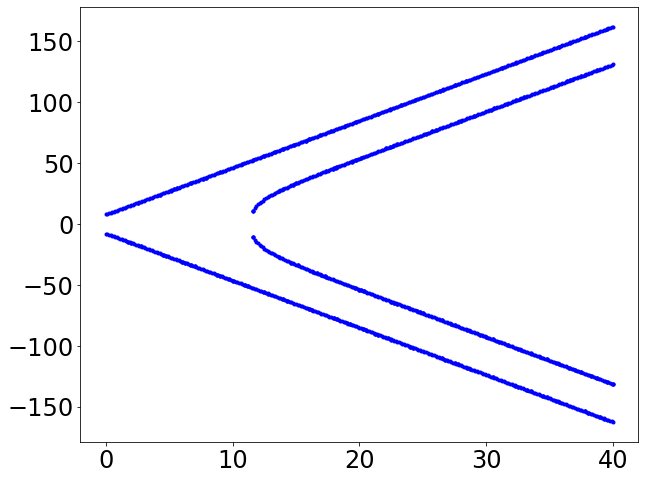

In [26]:
plt.figure(figsize=(10,8))
for t, front_list in zip(ts, fronts):
    plt.plot([t]*len(front_list), front_list, 'b.')

In [11]:
###############################################
# Animation ###################################

stride = 1

fig, axes = plt.subplots(2, 1, figsize=(12,12))
line_u, = axes[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = axes[0].plot(xs, us[0][1], 'm-', label="$a$")


line_j, = axes[1].plot(xs, js[0], 'g-', label="$j=u-a$")
#line_fronts, = axes[1].plot(fronts[0], [θ]*len(fronts[0]), 'go')
axes[1].plot(xs, 0*xs + θ, 'k--', label='$\\theta$')


y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[0].set_ylim(*window)

y_min = np.min(js)
y_max = np.max(js)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[1].set_ylim(*window)

for ax in axes:
    ax.legend(loc='right')
    ax.set_xlim(a,b)
    ax.set_ylim(-1.1, 1.1)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    #line_fronts.set_xdata(fronts[i])
    line_j.set_ydata(js[i])
    return line_u, 


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u, 

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

plt.close()
# anim.save('test.mp4', writer='imagemagick', fps=24)
HTML(anim.to_html5_video())

(15, 30)

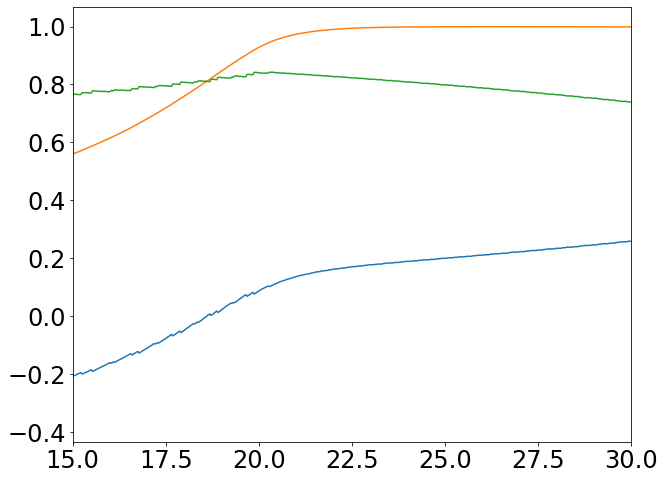

In [36]:
plt.figure(figsize=(10,8))
index = 100
plt.plot(xs, js[index])
plt.plot(xs, us[index][0])
plt.plot(xs, us[index][1])
plt.xlim(15, 30)

In [ ]:
forefront = np.array([front[1] for front in fronts])
aftfront = np.array([front[0] for front in fronts])

index_separation = 500
speeds_back = [ (f2[0]-f1[0])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]
speeds_front = [ (f2[1]-f1[1])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]

plt.figure(figsize=(15, 10))

plt.plot(ts[index_separation:], speeds_back, 'b-', label="aft speed")
plt.plot(ts[index_separation:], speeds_front, 'g-', label="fore speed")
plt.plot(ts[index_separation:], ts[index_separation:]*0 + c, 'k:', linewidth=5, label='analytic')

plt.xlabel('$t$')
plt.legend()
# plt.savefig('../reports/report20210610/front_speeds.png')
plt.show()
# print('t = %f' % ts[index])
print('k = %f' % k)
print('h = %f' % h)
print('h/k = %f' % (h/k))

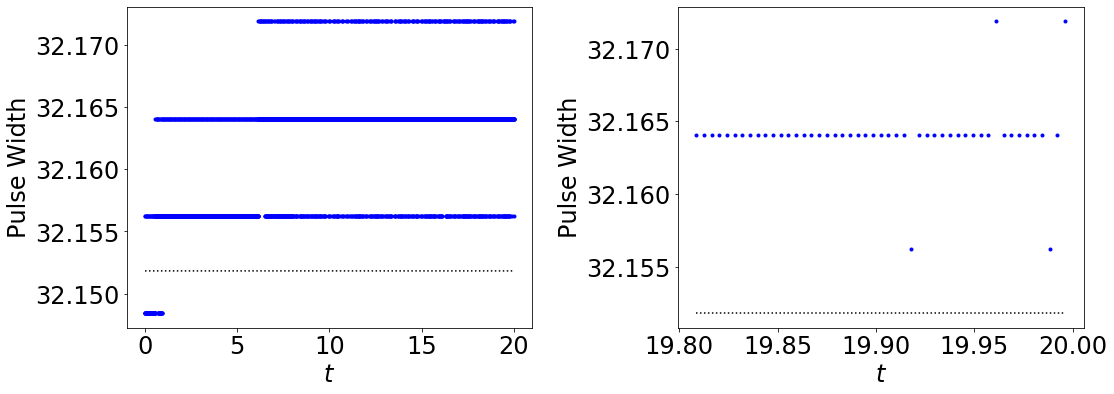

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

zoom_slice = slice(-50, -1)

axes[0].plot(ts, forefront-aftfront, 'b.')
axes[0].plot(ts, ts*0 + Δ, 'k:')
axes[1].plot(ts[zoom_slice], [front[1]-front[0] for front in fronts[zoom_slice]], 'b.')
axes[1].plot(ts[zoom_slice], ts[zoom_slice]*0 + Δ, 'k:')
for ax in axes:
    ax.set_xlabel('$t$')
    ax.set_ylabel('Pulse Width')
plt.tight_layout()
# plt.savefig('../reports/report20210610/pulse_widthds.png')
plt.show()

# Effects of Algorithm order on Pulse Speed

In [156]:
spatial_orders = [1, 2, 3, 4]
temporal_orders = [1, 4]

h = 2**-7
k = 2**-8

index_separation = 1000

# initialize
a, b_temp = -50, 150
t0, tf_temp = 0, 20

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

speeds_dictionary = {}

for spatial_order, temporal_order in product(spatial_orders, temporal_orders):
    print('Space: %d\t Time: %d' %( spatial_order, temporal_order) )
    F = partial(F_general, spatial_order=spatial_order, **param_dict)
    if temporal_order == 1:
        time_integrator_step = forward_Euler_step
    elif temporal_order == 4:
        time_integrator_step = RK4_step

    us = []
    js = []
    fronts = []
    ts = np.array([t0 + k*step for step in range(steps+1)])

    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_step, tf=tf) ):
        print('Step %d/%d' % (step, steps), end='\r')
        us += [u]
        js += [ u[0] - u[1] ]
        fronts.append( [refine_root(root_index, xs, js[-1]-θ, h, spatial_order=spatial_order) for root_index in find_root_indices(js[-1]-θ)] )
    print() # new line
    forefront = np.array([front[1] for front in fronts])
    aftfront = np.array([front[0] for front in fronts])


    speeds_back = [ (f2[0]-f1[0])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]
    speeds_front = [ (f2[1]-f1[1])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]
    
    speeds_dictionary[(spatial_order, temporal_order)] = [speeds_back, speeds_front]

Space: 1	 Time: 1
Step 5120/5120
Space: 1	 Time: 4
Step 5120/5120
Space: 2	 Time: 1
Step 5120/5120
Space: 2	 Time: 4
Step 5120/5120
Space: 3	 Time: 1
Step 5120/5120
Space: 3	 Time: 4
Step 5120/5120
Space: 4	 Time: 1
Step 5120/5120
Space: 4	 Time: 4
Step 5120/5120


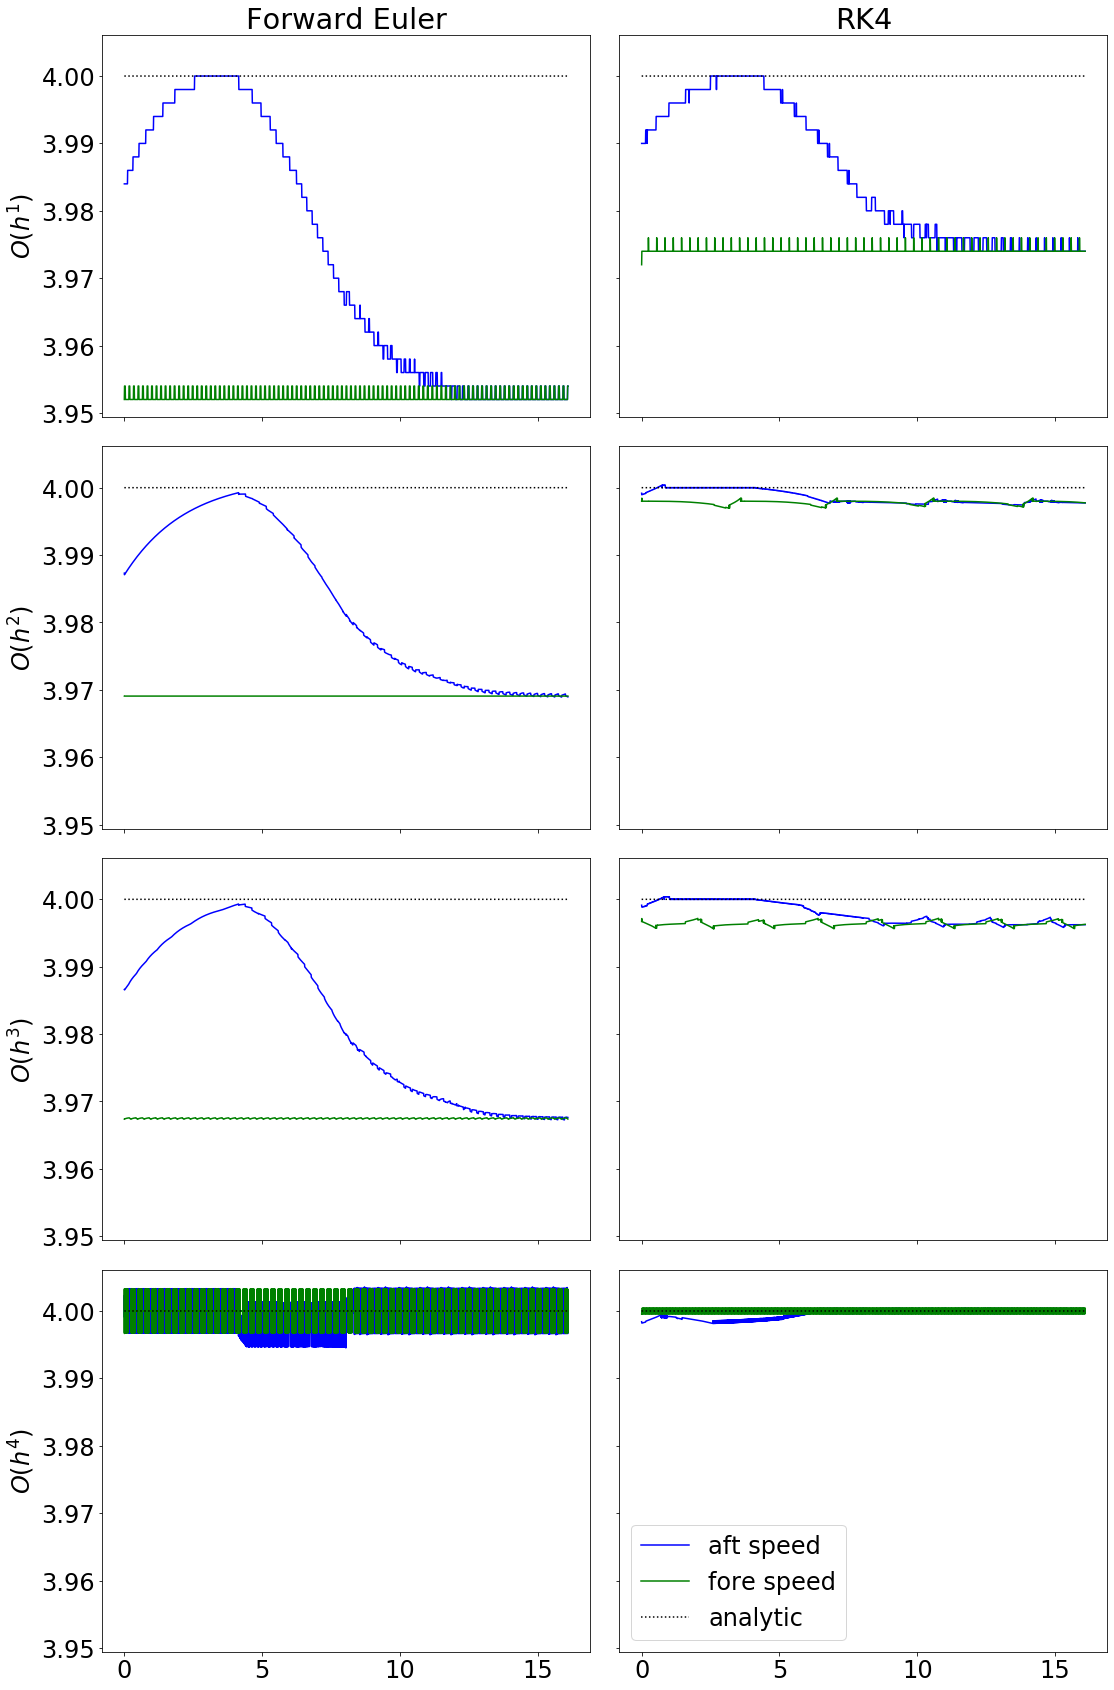

In [157]:
fig, axes = plt.subplots( len(spatial_orders), len(temporal_orders), figsize=(16, 24), sharex=True, sharey=True)

for spatial_index, spatial_order in enumerate(spatial_orders):
    for temporal_index, temporal_order in enumerate(temporal_orders):
        axes[spatial_index][temporal_index].plot( ts[:-index_separation], speeds_dictionary[(spatial_order, temporal_order)][0], 'b-', label="aft speed" )
        axes[spatial_index][temporal_index].plot( ts[:-index_separation], speeds_dictionary[(spatial_order, temporal_order)][1], 'g-', label="fore speed" )
        axes[spatial_index][temporal_index].plot( ts[:-index_separation], ts[:-index_separation]*0 + c, 'k:', label="analytic" )
        
axes[0][0].set_title('Forward Euler')
axes[0][1].set_title('RK4')
for spatial_index, spatial_order in enumerate(spatial_orders):
    axes[spatial_index][0].set_ylabel('$O(h^%d)$' % spatial_order)
plt.legend()
plt.tight_layout()
# plt.savefig('../reports/report20210624/order_comparisons.png')
plt.show()

# Wave response - Delta Pulse

In [85]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10

h = 2**-7
k = 2**-7

spatial_order = 1

# change the time-integrator to analytically account for the delta-pulse
I0 = 0.05
t_pulse = 1

def time_integrator_delta_pulse(F, x, t, u, dt, base_integrator=forward_Euler_step):
    ret = base_integrator(F, x, t, u, dt)
    if abs(t-t_pulse)/dt < 0.5:
        ret[0] += I0
    return ret

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

# create forcing function
F = partial(F_general, spatial_order=spatial_order, **param_dict)

us = []
js = []
fronts = []
ts = np.array([t0 + k*step for step in range(steps+1)])
for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_delta_pulse, tf=tf) ):
    print('Step %d/%d' % (step, steps), end='\r')
    us += [u]
    js += [ u[0] - u[1] ]
    fronts.append( [xs[i] for i in find_root_indices(js[-1]-θ) ] )

In [86]:
###############################################
# Animation ###################################

stride = 30

fig, axes = plt.subplots(2, 1, figsize=(12,12))
line_u, = axes[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = axes[0].plot(xs, us[0][1], 'm-', label="$a$")


line_j, = axes[1].plot(xs, js[0], 'g-', label="$j=u-a$")
line_fronts, = axes[1].plot(fronts[0], [θ]*len(fronts[0]), 'go')
axes[1].plot(xs, param_dict['θ'] + 0*xs, 'k--', label='$\\theta$')


y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[0].set_ylim(*window)

y_min = np.min(js)
y_max = np.max(js)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[1].set_ylim(*window)

for ax in axes:
    ax.legend(loc='right')
    ax.set_xlim(a,b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_fronts.set_xdata(fronts[i])
    line_j.set_ydata(js[i])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

plt.close()
HTML(anim.to_html5_video())

In [122]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10

h = 2**-7
k = 2**-9

spatial_order = 4
time_integration_step = RK4_step

I0s = [.01 * 2**(-i) for i in range(3)]
t_pulse = 1

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

# create forcing function
F = partial(F_general, spatial_order=spatial_order, **param_dict)

fore_fronts_list = []
aft_fronts_list = []

for I0 in I0s:
    print('I0 = %f' % I0)
    # change the time-integrator to analytically account for the delta-pulse
    def time_integrator_delta_pulse(F, x, t, u, dt, base_integrator=RK4_step):
        ret = base_integrator(F, x, t, u, dt)
        if abs(t-t_pulse)/dt < 0.5:
            ret[0] += I0
        return ret

    fore_fronts = []
    aft_fronts = []
    ts = np.array([t0 + k*step for step in range(steps+1)])
    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_delta_pulse, tf=tf) ):
        print('Step %d/%d' % (step, steps), end='\r')
        us += [u]
        js += [ u[0] - u[1] ]
        aft_front, fore_front = [refine_root(root_index, xs, u[0]-u[1]-θ, h, spatial_order=spatial_order) for root_index in find_root_indices(u[0]-u[1]-θ)]
        fore_fronts.append( fore_front )
        aft_fronts.append( aft_front )
    fore_fronts_list.append(np.array(fore_fronts))
    aft_fronts_list.append(np.array(aft_fronts))

I0 = 0.010000
I0 = 0.0050000
I0 = 0.0025000


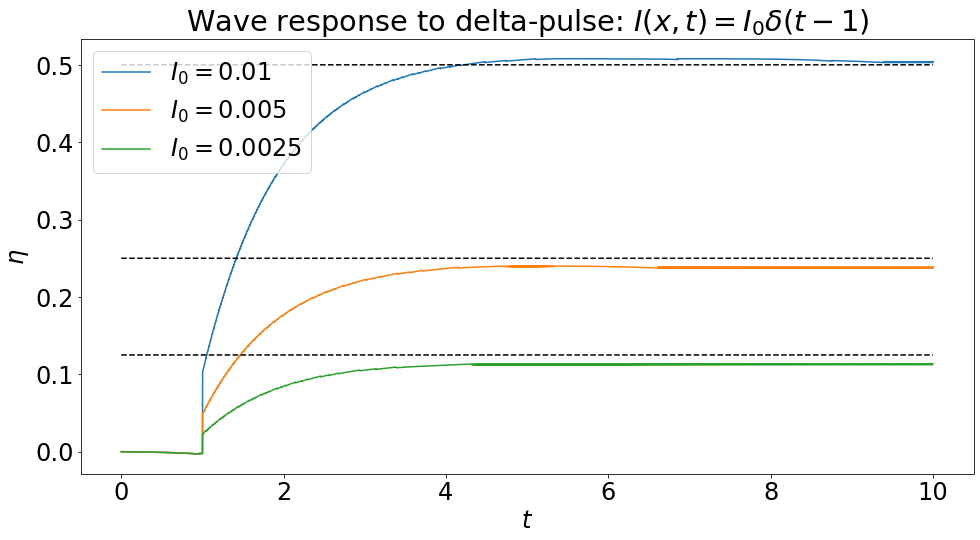

In [125]:
plt.figure(figsize=(16, 8))
for I0, fronts in zip(I0s, fore_fronts_list):
    plt.plot(ts, fronts - c*ts, label='$I_0=%g$'%I0)
    adjoint_method_response = (μ*c+1)/(μ * θ) * I0
    plt.plot(ts, np.array(ts)*0 + adjoint_method_response, 'k--')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\eta$')
plt.title('Wave response to delta-pulse: $I(x,t) = I_0 \delta(t-1)$')
plt.savefig('../reports/report20210624/delta_pulse.png')
plt.show()

# Wave response - Square Pulse

In [60]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10

h = 2**-7
k = 2**-7

spatial_order = 1
time_integrator_step = forward_Euler_step

# change the forcing function to account for the square pulse
I0 = 0.05
t_pulse_start, t_pulse_stop = 1, 2
F = partial(F_general, spatial_order=spatial_order, **param_dict)
def F_square_pulse(x,t,u):
    ret = F(x,t,u)
    if t_pulse_start <= t and t<= t_pulse_stop:
        ret[0] += I0
    return ret

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)


us = []
js = []
fronts = []
ts = np.array([t0 + k*step for step in range(steps+1)])
for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F_square_pulse, time_integrator_step=time_integrator_step, tf=tf) ):
    print('Step %d/%d' % (step, steps), end='\r')
    us += [u]
    js += [ u[0] - u[1] ]
    fronts.append( [xs[i] for i in find_root_indices(js[-1]-θ) ] )

In [61]:
###############################################
# Animation ###################################

stride = 30

fig, axes = plt.subplots(2, 1, figsize=(12,12))
line_u, = axes[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = axes[0].plot(xs, us[0][1], 'm-', label="$a$")


line_j, = axes[1].plot(xs, js[0], 'g-', label="$j=u-a$")
line_fronts, = axes[1].plot(fronts[0], [θ]*len(fronts[0]), 'go')
axes[1].plot(xs, param_dict['θ'] + 0*xs, 'k--', label='$\\theta$')


y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[0].set_ylim(*window)

y_min = np.min(js)
y_max = np.max(js)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[1].set_ylim(*window)

for ax in axes:
    ax.legend(loc='right')
    ax.set_xlim(a,b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_fronts.set_xdata(fronts[i])
    line_j.set_ydata(js[i])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

plt.close()
HTML(anim.to_html5_video())

### Measure Wave response

In [90]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10
h = 2**-7
k = 2**-8
spatial_order = 2
# time_integrator_step = forward_Euler_step
time_integrator_step = RK4_step

t_pulse_start, t_pulse_stop = 1, 2
I0s = [-.05, -.01, .01, .05]

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

front_lists = []
for I0 in I0s:
    print('I0: %f' % I0)
    # change the forcing function to account for the square pulse
    F = partial(F_general, spatial_order=spatial_order, **param_dict)
    def F_square_pulse(x,t,u):
        ret = F(x,t,u)
        if t_pulse_start <= t and t<= t_pulse_stop:
            ret[0] += I0
        return ret
    fronts = []
    ts = np.array([t0 + k*step for step in range(steps+1)])
    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F_square_pulse, time_integrator_step=time_integrator_step, tf=tf) ):
        print('Step %d/%d' % (step, steps), end='\r')
        fore_front_index = find_root_indices(u[0]-u[1]-θ)[1]
        fronts.append( xs[fore_front_index]  )
    print() # next line
        
    front_lists.append(np.array(fronts))

I0: -0.050000
Step 2560/2560
I0: -0.010000
Step 2560/2560
I0: 0.010000
Step 2560/2560
I0: 0.050000
Step 2560/2560


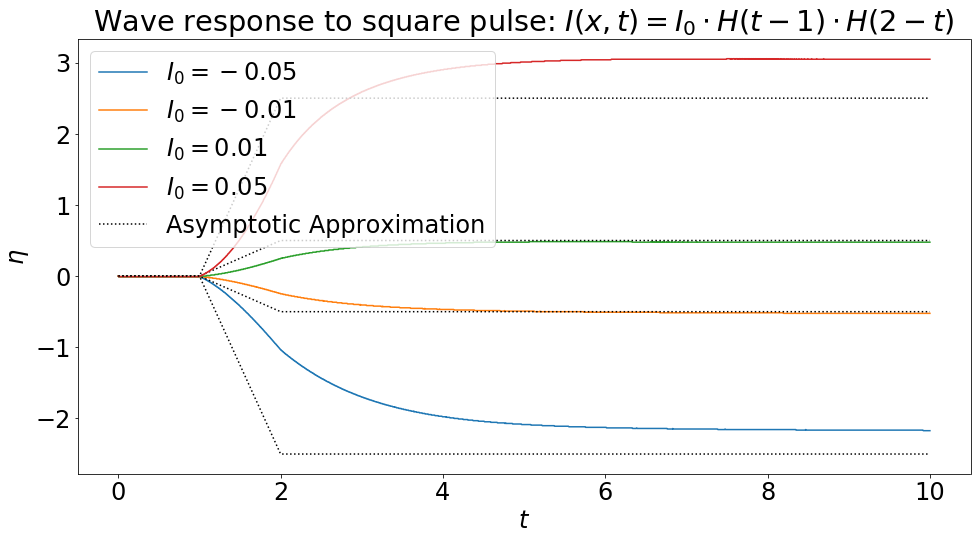

In [99]:
plt.figure(figsize=(16, 8))
for I0, fronts in zip(I0s, front_lists):
    plt.plot(ts, fronts - c*ts, label='$I_0=%g$'%I0)
    plt.plot(ts, (μ*c+1)/μ/θ * I0 * ( (ts-1)*np.heaviside(ts-1,.5)*np.heaviside(2-ts,.5) + np.heaviside(ts-2, 0.5)), 'k:'  )
plt.plot(0,0, 'k:', label='Asymptotic Approximation')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\eta$')
plt.title('Wave response to square pulse: $I(x,t) = I_0\cdot H(t-1) \cdot H(2-t)$')
# plt.savefig('../reports/report20210624/sqare_pulse.png')
plt.show()

# Convergence Study

In [83]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10
k = 2**-10
hs = [2**-i for i in range(2, 7)]
spatial_order = 3

time_integrator_step = RK4_step

F = partial(F_general, spatial_order=spatial_order, **param_dict)
errors = []
for h in hs:
    print('h: %f' % h)
    # initialze space
    n = ceil( (b_temp - a)/h ) + 1
    b = a + h*(n-1)
    xs = np.linspace(a, b, n)
    # adjust stopping time
    steps = ceil( (tf_temp-t0)/k )
    tf = t0 + k*steps
    # initialze traveling pulse solution
    u0 = np.empty((2, n))
    u0[0] = Unum(xs, **param_dict)
    u0[1] = Anum(xs, **param_dict)
    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_step, tf=tf) ):
        print('Step %d/%d' % (step, steps), end='\r')
        t += k
    print()
    errors.append( (la.norm(u[0]-Unum(xs-c*tf, **param_dict)) + la.norm(u[1]-Anum(xs-c*tf, **param_dict)))*h )

h: 0.250000
Step 10240/10240
h: 0.125000
Step 10240/10240
h: 0.062500
Step 10240/10240
h: 0.031250
Step 10240/10240
h: 0.015625
Step 10240/10240


In [82]:
[ np.log(e1/e2)/np.log(h1/h2) for e1, e2, h1, h2 in zip(errors[1:], errors[:-1], hs[1:], hs[:-1]) ]

[1.4568483436060995, 1.4236414244669162, 1.356136056194809, 1.1886626076488835]

### convergence in time

In [88]:
a, b_temp = -50, 150
t0, tf_temp = 0, 10
ks = [2**-i for i in range(6, 10)]
h = 2**-6
spatial_order = 4
time_integrator_step = RK4_step

F = partial(F_general, spatial_order=spatial_order, **param_dict)
errors = []
for k in ks:
    print('h: %f' % h)
    # initialze space
    n = ceil( (b_temp - a)/h ) + 1
    b = a + h*(n-1)
    xs = np.linspace(a, b, n)
    # adjust stopping time
    steps = ceil( (tf_temp-t0)/k )
    tf = t0 + k*steps
    # initialze traveling pulse solution
    u0 = np.empty((2, n))
    u0[0] = Unum(xs, **param_dict)
    u0[1] = Anum(xs, **param_dict)
    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_step, tf=tf) ):
        print('Step %d/%d' % (step, steps), end='\r')
        t += k
    print()
    errors.append( (la.norm(u[0]-Unum(xs-c*tf, **param_dict)) + la.norm(u[1]-Anum(xs-c*tf, **param_dict)))*h )

h: 0.015625
Step 640/640
h: 0.015625
Step 1280/1280
h: 0.015625
Step 2560/2560
h: 0.015625
Step 5120/5120


In [89]:
[ np.log(e1/e2)/np.log(h1/h2) for e1, e2, h1, h2 in zip(errors[1:], errors[:-1], hs[1:], hs[:-1]) ]

[1.8270230595374126, -0.09626633502574646, -1.3787207140643905]

# Spatially localized pulse

In [82]:
a, b_temp = -50, 150
t0, tf_temp = 0, 20

h = 2**-5
k = 2**-6

tp = 1 # temporal location of the pulse
Δx = 5
xp = 0 + c*tp
# x_right = -10

spatial_order = 4

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

# create forcing function
F = partial(F_general, spatial_order=spatial_order, **param_dict)

# change the time-integrator to analytically account for the delta-pulse
I0 = 0.2
def time_integrator_delta_pulse(F, x, t, u, dt, base_integrator=forward_Euler_step):
    ret = base_integrator(F, x, t, u, dt)
    if abs(t-tp)/dt < 0.5:
        ret[0] += I0 * np.heaviside(Δx - np.abs(xs - xp), 0.5)
    return ret
us = []
I0 = 0.1
def time_integrator_delta_pulse(F, x, t, u, dt, base_integrator=forward_Euler_step):
    ret = base_integrator(F, x, t, u, dt)
    if abs(t-t_pulse)/dt < 0.5:
        ret[0] += I0 * np.heaviside(Δx - np.abs(xs - xp), 0.5)
    return ret

ts = np.array([t0 + k*step for step in range(steps+1)])
us = []
for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_delta_pulse, tf=tf) ):
    print('Step %d/%d' % (step, steps), end='\r')
    us += [ u ]

In [83]:
js = [ u[0]-u[1] for u in us ]
###############################################
# Animation ###################################

stride = 10

fig, axes = plt.subplots(2, 1, figsize=(12,12))
line_u, = axes[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = axes[0].plot(xs, us[0][1], 'm-', label="$a$")


line_j, = axes[1].plot(xs, js[0], 'g-', label="$j=u-a$")
axes[1].plot(xs, param_dict['θ'] + 0*xs, 'k--', label='$\\theta$')


y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[0].set_ylim(*window)

y_min = np.min(js)
y_max = np.max(js)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[1].set_ylim(*window)

for ax in axes:
    ax.legend(loc='right')
    ax.set_xlim(a,b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_j.set_ydata(js[i])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

plt.close()
HTML(anim.to_html5_video())

In [61]:
a, b_temp = -50, 150
t0, tf_temp = 0, 20

h = 2**-7
k = 2**-7

t_pulse = 1 # temporal location of the pulse
Δx = 5
I0s = [0.05, 0.01, -0.01, -0.05]
xp_list = np.linspace(-Δx, Δx*3, 401) + c*t_pulse

spatial_order = 2
base_time_stepper = RK4_step

# initialze space
n = ceil( (b_temp - a)/h ) + 1
b = a + h*(n-1)
xs = np.linspace(a, b, n)

# adjust stopping time
steps = ceil( (tf_temp-t0)/k )
tf = t0 + k*steps

# initialze traveling pulse solution
u0 = np.empty((2, n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)

# create forcing function
F = partial(F_general, spatial_order=spatial_order, **param_dict)


wave_responses = {}
for sim_index, (xp, I0) in enumerate(product(xp_list, I0s)):
    # change the time-integrator to analytically account for the delta-pulse
    def time_integrator_delta_pulse(F, x, t, u, dt, base_integrator=base_time_stepper):
        ret = base_integrator(F, x, t, u, dt)
        if abs(t-t_pulse)/dt < 0.5:
            ret[0] += I0 * np.heaviside(Δx/2 - np.abs(xs - xp), 0.5)
        return ret

    for step, u in zip(range(steps+1), solution_sequence(xs, t0, k, u0, F, time_integrator_step=time_integrator_delta_pulse, tf=tf) ):
        print('Simulation %d/%d\tStep %d/%d          ' % (sim_index+1, len(I0s)*len(xp_list), step, steps), end='\r')
    wave_responses[(xp, I0)] = find_roots(xs, u[0]-u[1]-θ, h, spatial_order=spatial_order)[-1] - c*tf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Order 2 interpolation failed. Reverting to Order 1 interpolation.


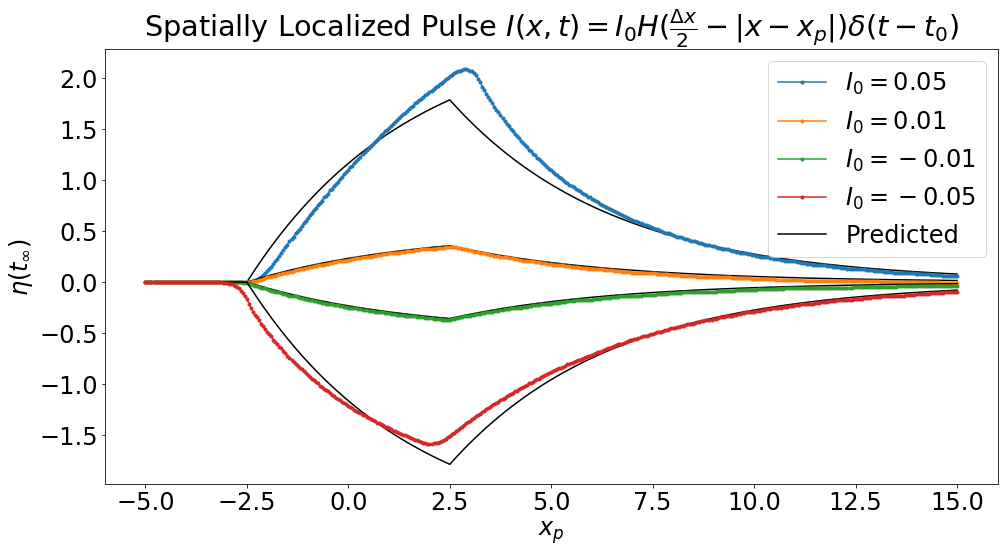

In [69]:
def response_analytic(xp, Δx, I0):
    ret = 0*xp
    mask_left = (xp+Δx/2) <= 0
    mask_right = 0 < (xp-Δx/2)
    mask_mid = ~(mask_right | mask_left)
    
    ret[mask_left] += 0
    ret[mask_mid] += 1 - np.exp( -(xp[mask_mid]+Δx/2)/c/μ )
    ret[mask_right] += np.exp(-(xp[mask_right]-Δx/2)/c/μ) - np.exp(-(xp[mask_right]+Δx/2)/c/μ)
    
    return (μ*c+1)/μ/θ*I0 * ret

zs = np.linspace(xp_list[0], xp_list[-1], 201)
fig = plt.figure(figsize=(16, 8))
for I0 in I0s:
    plt.plot(zs-c*t_pulse, response_analytic(np.array(zs)-c*t_pulse, Δx, I0), 'k-')
    plt.plot(xp_list-c*t_pulse , [wave_responses[(xp, I0)] for xp in xp_list], '.-', label='$I_0=%g$'%I0)

plt.plot([], [], 'k-', label='Predicted')
plt.legend()
plt.xlabel('$x_p$')
plt.ylabel('$\eta(t_\infty)$')
plt.title('Spatially Localized Pulse $I(x,t) = I_0 H(\\frac{\Delta x}{2} - |x - x_p|) \delta(t-t_0)$')
plt.savefig('../reports/report20210707/spatially_localized_wave_response.png')

plt.show()

In [63]:
pickle.dump([xp_list, I0s, wave_responses], open('local_pulse_wave_response.pickle', 'wb'))